In [1]:
import pandas as pd
import numpy as np
import math as mt
from pandas import ExcelWriter

In [2]:
hu_df = pd.read_excel('Hu TA Counters.xlsx')
nk_df = pd.read_excel('TA_Nokia.xlsx')

In [3]:
# average pd - Huawei
hu_df['total'] = np.nan
hu_df['total'] = hu_df.iloc[:,3:].sum(axis = 1)
a = np.zeros(39)
d = 550
a[:30] = np.arange(0, 30*d, d)
a[30:] = np.array([30.5, 34.5, 36.5, 38.5, 42, 47, 52, 59, 66])*d
a[0] = 275/2
hu_df['ave_ta'] = np.nan
hu_df['ave_ta'] = hu_df.iloc[:,3:-2].dot(a)/hu_df['total']
hu_dfa = hu_df[(hu_df['ElementID1'].str[2] == '1') & (hu_df['ElementID1'].str.len()==9)].copy()

hu_df_a = hu_dfa.groupby('ElementID1',as_index = False).mean()

# average pd - Nokia
nk_df['total'] = np.nan
nk_df['total'] = nk_df.iloc[:,3:].sum(axis = 1)
d = 550
a = np.arange(0, 64*d, d)
a[0] = 550/2/2
nk_df['ave_ta'] = np.nan
nk_df['ave_ta'] = nk_df.iloc[:,3:-2].dot(a)/nk_df['total']
nk_dfa = nk_df[(nk_df['ElementID1'].str[2] == '1') & (nk_df['ElementID1'].str.len()==9)].copy()

nk_df_a = nk_dfa.groupby('ElementID1',as_index = False).mean()


In [4]:
hu_df_a = hu_df_a[['ElementID1','ave_ta']]
nk_df_a = nk_df_a[['ElementID1','ave_ta']]
pd_ta = pd.concat((hu_df_a,nk_df_a))
pd_ta = pd_ta[np.isfinite(pd_ta['ave_ta'])]
pd_ta.reset_index(drop=True, inplace = True)
pd_ta['Sector'] = np.nan
pd_ta.loc[pd_ta.index,'Sector'] = \
pd_ta.loc[pd_ta.index,'ElementID1'].str[:2] +  pd_ta.loc[pd_ta.index,'ElementID1'].str[4:] 

### Cell to Cell Distance

In [5]:
#c2cd_fn_macro = 'D:\\Work\\CellBehaviour\\Cell2CellDistance.xlsx'
c2cd_fn = 'D:\\Work\\CellBehaviour\\Cell2CellDistance_8_3_2019.xlsx'

#c2c_macro = pd.read_excel(c2cd_fn_macro)
c2c = pd.read_excel(c2cd_fn)
c2c = c2c[(c2c['Distance_Result']>30) & (~c2c['Origin'].str[2:4].isin(['40','60','70']))]
print(len(c2c))
#print(len(c2c_macro))
#print(len(c2c[c2c['Origin'].isin(c2c_macro['Origin'].tolist())]))
#print(len(c2c[c2c['Origin'].str[2:4].isin(['40','60','70'])]))

pd_ta_c2c = pd.merge(pd_ta,c2c, left_on = 'Sector', right_on = 'Origin')
pd_ta_c2c = pd_ta_c2c[['Sector','ave_ta','Distance_Result']]



73748


In [19]:
#print(len(c2c[c2c['Origin'].str[2:4].isin(['40','60','70'])]))
print(len(c2c[c2c['Distance_Result']<20]))

570


<IPython.core.display.Javascript object>


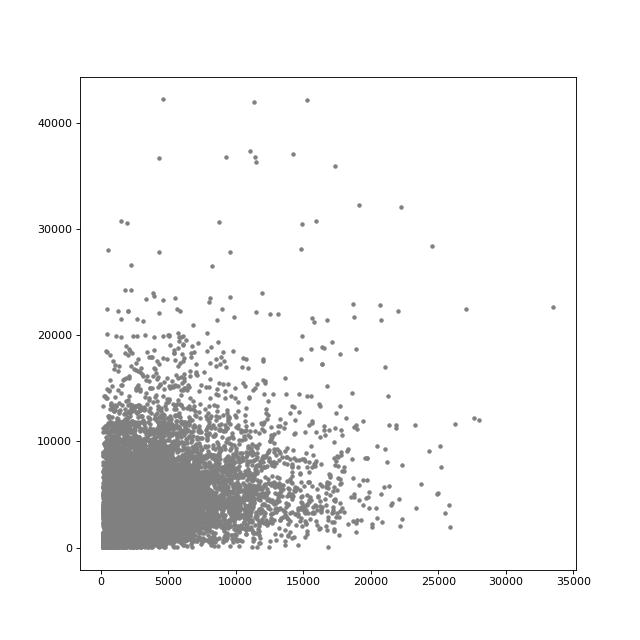

In [27]:
import pylab as plt   
%matplotlib notebook
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(pd_ta_c2c['ave_ta'],pd_ta_c2c['Distance_Result'],marker = '.', color = 'gray')
#plt.xlim(0, 80000)
#plt.ylim(0, 80000)

## Clustering

In [32]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X = pd_ta_c2c[['ave_ta','Distance_Result']].values
pre_1 = False

## preprocess
if pre_1:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
else:
    from sklearn.preprocessing import MinMaxScaler
    Xl = np.log10(1+X)
    #Xl = X.copy()
    scaler = MinMaxScaler()
    scaler.fit(Xl)
    Xl = scaler.transform(Xl)
    X = np.zeros((np.shape(Xl)[0],2))#Xl.copy()
    #X = Xl.copy()
    X[:,0] = Xl[:,0]*np.cos(Xl[:,1]*np.pi/2)
    X[:,1] = Xl[:,0]*np.sin(Xl[:,1]*np.pi/2)
    
    #X[:,2] = Xl[:,1]*np.cos(Xl[:,0]*np.pi/2)
    #X[:,3] = Xl[:,1]*np.sin(Xl[:,0]*np.pi/2)
    
nC = 6
kmeans = KMeans(n_clusters = nC, random_state = 0).fit(X)

pd_ta_c2c['labels'] = np.nan
pd_ta_c2c.loc[:,'labels'] = kmeans.labels_.tolist()
#pd_ta_c2c.loc[list(ind),'labels'] = kmeans.labels_.tolist()
#pd_ta_c2c['labels'] = np.nan
#pd_ta_c2c.loc[ind,'labels'] = kmeans.labels_.tolist()
writer = ExcelWriter('ta_1G_' + str(nC) + '.xlsx')# '3p_max_8_amp_diff.xlsx')
pd_ta_c2c.to_excel(writer, index=False)
writer.save()
#print(kmeans.cluster_centers_)
if pre_1:
    xx = scaler.inverse_transform(kmeans.cluster_centers_)
else:
    xx = kmeans.cluster_centers_.copy()
    xx[:,0] = np.sqrt(kmeans.cluster_centers_[:,0]**2 + kmeans.cluster_centers_[:,1]**2)
    xx[:,1] = np.arctan(kmeans.cluster_centers_[:,1]/kmeans.cluster_centers_[:,0])*2/np.pi
    
    #xx[:,2] = np.sqrt(kmeans.cluster_centers_[:,2]**2 + kmeans.cluster_centers_[:,3]**2)
    #xx[:,3] = np.arctan(kmeans.cluster_centers_[:,3]/kmeans.cluster_centers_[:,2])*2/np.pi
    
    xx = scaler.inverse_transform(xx[:,:2])
    xx = np.power(10, xx)-1
print(xx)

for i in range(nC):
    print(np.count_nonzero(kmeans.labels_ == i))



[[1165.10157835 3626.88774607]
 [ 631.59485671  691.95255629]
 [7334.08661488 5491.79018024]
 [2020.56270172  807.83788911]
 [2901.9284489  4292.20608083]
 [ 312.80696518  436.72505158]]
5382
8416
3731
2970
6399
8480


<IPython.core.display.Javascript object>


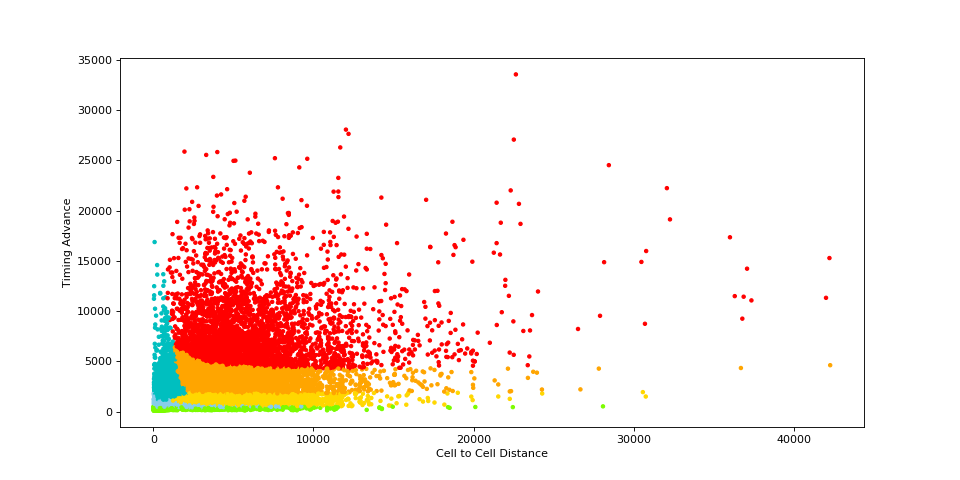

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Timing Advance')

In [36]:
import pylab as plt
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
if pre_1:
    xx2 = scaler.inverse_transform(X)
else:
    #xx2 = X.copy()
    xx2 = np.zeros(( np.shape(X)[0], 2))
    xx2[:,0] = np.sqrt(X[:,0]**2 + X[:,1]**2)
    xx2[:,1] = np.arctan(X[:,1]/X[:,0])*2/np.pi
    
    #xx2[:,2] = np.sqrt(X[:,0]**2 + X[:,1]**2)
    #xx2[:,3] = np.arctan(X[:,1]/X[:,0])*2/np.pi
    
    xx2 = scaler.inverse_transform(xx2[:,:2])
    xx2 = np.power(10, xx2)-1
    
# clrs = ['lawngreen','gold','blue','red','skyblue','orange','c','g']
#clrs = ['c','lawngreen','red','orange','gold','g','skyblue','blue']
#clrs = ['lawngreen','orange','gold','skyblue','c','r']#,'skyblue','blue']
clrs = ['gold','skyblue','r','c','orange','lawngreen']#,'skyblue','blue']

cmap_name = 'my_clr_map'
cm = LinearSegmentedColormap.from_list(cmap_name, clrs, N = len(clrs))
plt.scatter(xx2[:,1], xx2[:,0], c = kmeans.labels_.tolist(),cmap = cm, marker = '.')
#plt.scatter(xx2[:,1], xx2[:,0], c = 'gray',cmap = cm, marker = '.')
#plt.plot([0, 8000],[0, 8000],color = 'red')
#plt.axis('equal')
plt.xlabel('Cell to Cell Distance')
plt.ylabel('Timing Advance')

In [30]:
pd_ta_c2c[(pd_ta_c2c['ave_ta']>14000) & (pd_ta_c2c['Distance_Result']<100)]

,Sector,ave_ta,Distance_Result,labels
21549,QN1762B,16867.191229,79.261801,1


## Quantile

In [37]:
X = pd_ta_c2c[['ave_ta','Distance_Result']].values
lbls = np.zeros(np.shape(X)[0])
lbls[np.where(X[:,1] >= 1777)] = 3
lbls[np.where(X[:,0] >= 800)] = lbls[np.where(X[:,0] >= 800)]+1
lbls[np.where(X[:,0] >= 5500)] = lbls[np.where(X[:,0] >= 5500)]+1

pd_ta_c2c['labels'] = np.nan
pd_ta_c2c.loc[:,'labels'] = lbls.tolist()
nC = 6
pd_ta_c2c['labels'] = np.nan
pd_ta_c2c.loc[:,'labels'] = lbls.tolist()
writer = ExcelWriter('ta_quantile_' + str(nC) + '.xlsx')# '3p_max_8_amp_diff.xlsx')
pd_ta_c2c.to_excel(writer, index=False)
writer.save()
    
for i in range(nC):
    print(np.count_nonzero(lbls == i))

13585
5097
213
2087
11581
2815


<IPython.core.display.Javascript object>


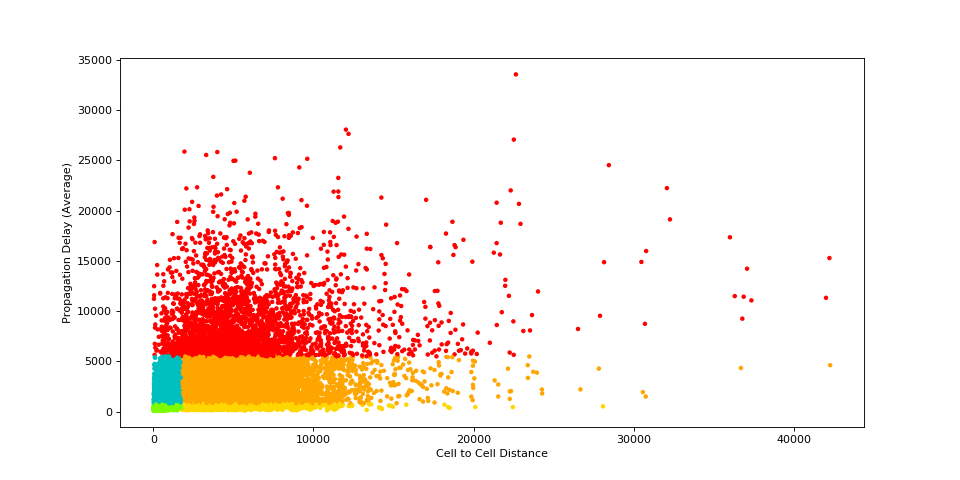

Text(0, 0.5, 'Propagation Delay (Average)')

In [38]:
import pylab as plt
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

xx2 = X.copy()
#xx2[:,0] = np.sqrt(X[:,0]**2 + X[:,1]**2)
#xx2[:,1] = np.arctan(X[:,1]/X[:,0])*2/np.pi
#xx2 = scaler.inverse_transform(xx2)
#xx2 = np.power(10, xx2)-1
    
# clrs = ['lawngreen','gold','blue','red','skyblue','orange','c','g']
clrs = ['lawngreen','c','red','gold','orange','red']#,'skyblue','blue']
cmap_name = 'my_clr_map'
cm = LinearSegmentedColormap.from_list(cmap_name, clrs, N = len(clrs))
plt.scatter(xx2[:,1], xx2[:,0], c = lbls,cmap = cm, marker = '.')
#plt.scatter(xx2[:,1], xx2[:,0], c = 'gray',cmap = cm, marker = '.')
#plt.plot([0, 8000],[0, 8000],color = 'red')
#plt.axis('equal')
plt.xlabel('Cell to Cell Distance')
plt.ylabel('Propagation Delay (Average)')

## Change zero labels in the excel files

In [45]:
macro_fn = 'D:\\Work\\CellBehaviour\\TCH\\maps\\Sector DB.xlsx'
df_macro = pd.read_excel(macro_fn)
# get rid of micro sites
df_macro = df_macro[~(df_macro['Sector'].str[2].isin(['4','6','7']))]
label_fn = 'ta_1G_6.xlsx'
df_label = pd.read_excel(label_fn)

df_macro2 = df_macro.merge(df_label[['Sector','label_ta_clstr']], left_on = ['Sector'], right_on = ['Sector'], how = 'inner')

label_fn = 'ta_quantile_6.xlsx'
df_label = pd.read_excel(label_fn)

df_macro2 = df_macro2.merge(df_label[['Sector','label_ta_qntl']], left_on = ['Sector'], right_on = ['Sector'], how = 'inner')


writer = ExcelWriter('D:\\Work\\CellBehaviour\\TCH\\maps\\Macro Sites TA.xlsx')# '3p_max_8_amp_diff.xlsx')
df_macro2.to_excel(writer, index=False)
writer.save()

In [40]:
df_label.columns

Index(['Sector', 'ave_ta', 'Distance_Result', 'labels', 'label_ta_qntl'], dtype='object')